In [124]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import os
import astropy as ap
from astropy.io import ascii
from astropy.io.ascii import masked
from pylab import *
from astropy.io import fits

# Retrieve catalog from Holwerda et al. (2015)

In [125]:
data = pd.read_csv("holwerda15.csv")
filtered_pairs = data[data["spec_type"] == "PG+ELG"]
all_pairs = data[["ra","dec","z1","z2","spec_type"]]
z1_all_pairs = data["z1"]

# Histogram of redshifts 

Using this 4-class diverging color scheme that's colorblind safe, 
print friendly, and photocopy safe: http://colorbrewer2.org/#type=diverging&scheme=PuOr&n=4

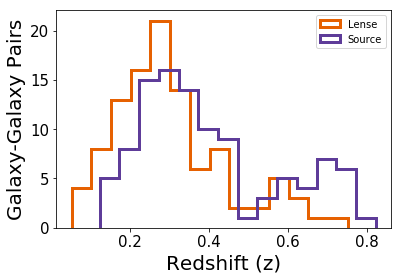

In [126]:
z1 = filtered_pairs['z1']
z2 = filtered_pairs['z2']

nbins = 30
binwidth = 0.05

plt.hist(z1, histtype='step', linewidth=3, color='#e66101', bins=np.arange(min(z1), max(z1) + binwidth, binwidth), label='Lense')
plt.hist(z2, histtype='step', linewidth=3, linestyle='-', color='#5e3c99', bins=np.arange(min(z2), max(z2) + binwidth, binwidth), label='Source')
plt.legend(loc='upper right', numpoints=2)
        
plt.tick_params(axis='both', which='major', labelsize=15)
plt.tick_params(axis='both', which='minor', labelsize=15)
plt.ylabel('Galaxy-Galaxy Pairs', fontsize=20)
plt.xlabel(r'Redshift (z)', fontsize=20)

plt.show()

(Specific star formation rate (sSFR) = SFR vs. M* goes here) (Cluver et al. (2014))

(M* vs. Z goes here)

(Einstein Radius vs. M* for each land/space telescope FOV goes here)

(Source Redshift vs. H-Alpha Wavelength for each land/space telescope FOV goes here)

# Import WISE data

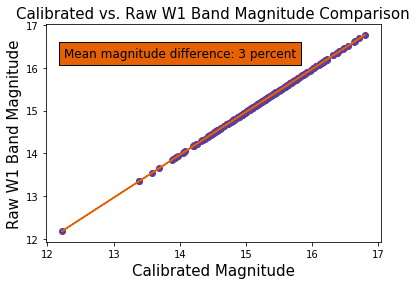

In [127]:
# Read in results from targets.tbl upload, all KiDS Targets
filename = "results.tbl"
wise_data = ap.io.ascii.read(filename, data_start=0, delimiter='|')
df = wise_data.to_pandas()
w1 = df.w1mpro
w2 = df.w2mpro
w1flux = df.w1flux

# I was curious what the calibrated magnitude based on flux counts, aperture corrections, and instrumental zero point mags would be...
# See here: http://wise2.ipac.caltech.edu/docs/release/allsky/expsup/sec4_4h.html#example
M_zpt = 20.752
aper_corr = 0.222 # Found here: http://wise2.ipac.caltech.edu/docs/release/allsky/expsup/sec4_4c.html#circ
M_cal = M_zpt - 2.5*log10(w1flux)-aper_corr

meanDiff=mean(abs(M_cal-w1))*100

p = plt.title("Calibrated vs. Raw W1 Band Magnitude Comparison",fontsize=15)
p = plt.scatter(M_cal,w1,color='#5e3c99')
m,c=np.polyfit(M_cal,w1,1)
p = plt.plot(M_cal,m*M_cal + c, color='#e66101')
p = plt.xlabel("Calibrated Magnitude",fontsize=15)
p = plt.ylabel("Raw W1 Band Magnitude",fontsize=15)
p = plt.text(12.25, 16.25, 'Mean magnitude difference: %d percent' %meanDiff, style='normal', fontsize=12, bbox={'facecolor':'#e66101', 'alpha':1, 'pad':5})

# Calculations

My Mstar looked off, so I opted to use Mstar ~ 0.6*W1

In [158]:
# all_pairs.count()
# df.count()

merged_data = pd.merge(df, all_pairs, how = 'left', left_on = 'ra_01', right_on = 'ra')

# This relation comes from Cluver et al. (2014) p. 7 Eq (2)
log_Mstar_Lum_W1 = -1.96*(merged_data.w1mpro - merged_data.w2mpro)-0.03

## My log(M*) doesn't look right...
log_Mstar = 10**(-1.96*(merged_data.w1mpro - merged_data.w2mpro) - 0.03 - 0.4*(merged_data.w1mpro-3.24))
#print(log_Mstar)

## Comparing log_Mstar to 0.6*W1...
#Mstar_from_flux = 0.6*merged_data.w1mpro
#print(Mstar_from_flux)

observed_color_W1 = merged_data.w1mpro - merged_data.w2mpro #W1-W2
observed_color_W3 = merged_data.w2mpro - merged_data.w3mpro #W2-W3

# WISE log(M/L) vs W1-W2, All Pairs (why so linear?)

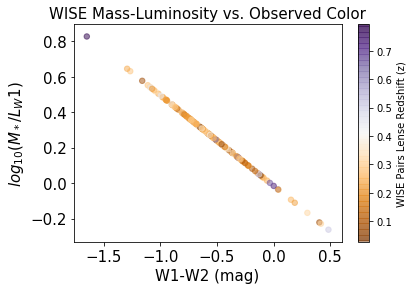

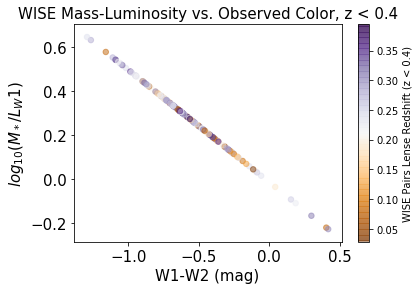

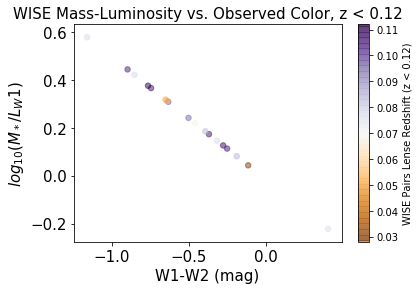

In [129]:
# Plotting all pairs, all redshifts
plt.figure()
plt.subplot(111)
plt.title("WISE Mass-Luminosity vs. Observed Color",fontsize=15)
p = plt.scatter(log_Mstar_Lum_W1,observed_color_W1, marker='o', s=30, alpha=0.5, c=merged_data.z1, cmap=cm.PuOr)
#p = plt.scatter(log_Mstar_Lum_W1,observed_color_W3, marker='o', s=30, alpha=0.5, c=merged_data.z1, cmap=cm.PuOr)

    
p = plt.cbar = plt.colorbar(p, shrink=1, orientation='vertical') #, anchor=(0,1.5))
p = plt.cbar.set_label('WISE Pairs Lense Redshift (z)', fontsize=10)
p = plt.tick_params(axis='both', which='major', labelsize=15)
p = plt.tick_params(axis='both', which='minor', labelsize=15)

p = plt.ylabel(r'$log_{10}(M_*/L_W1)$', fontsize=15)
p = plt.xlabel(r'W1-W2 (mag)', fontsize=15)

# Plotting all pairs where z < 0.4

log_Mstar_Lum_W1_lowz = -1.96*(merged_data[merged_data.z1 < 0.4].w1mpro - merged_data[merged_data.z1 < 0.4].w2mpro)-0.03
observed_color_W1_lowz = merged_data[merged_data.z1 < 0.4].w1mpro - merged_data[merged_data.z1 < 0.4].w2mpro #W1-W2
observed_color_W3_lowz = merged_data[merged_data.z1 < 0.4].w2mpro - merged_data[merged_data.z1 < 0.4].w3mpro #W2-W3


plt.figure()
plt.subplot(111)
plt.title("WISE Mass-Luminosity vs. Observed Color, z < 0.4",fontsize=15)
p = plt.scatter(log_Mstar_Lum_W1_lowz,observed_color_W1_lowz, s=30, marker='o', alpha=0.5, c=merged_data[merged_data.z1 < 0.4].z1, cmap=cm.PuOr)
    
p = plt.cbar = plt.colorbar(p, shrink=1, orientation='vertical') #, anchor=(0,1.5))
p = plt.cbar.set_label('WISE Pairs Lense Redshift (z < 0.4)', fontsize=10)
p = plt.tick_params(axis='both', which='major', labelsize=15)
p = plt.tick_params(axis='both', which='minor', labelsize=15)
p = plt.ylabel(r'$log_{10}(M_*/L_W1)$', fontsize=15)
p = plt.xlabel(r'W1-W2 (mag)', fontsize=15)

# Plotting all pairs where z < 0.12

log_Mstar_Lum_W1_lowestz = -1.96*(merged_data[merged_data.z1 < 0.12].w1mpro - merged_data[merged_data.z1 < 0.12].w2mpro)-0.03
observed_color_W1_lowestz = merged_data[merged_data.z1 < 0.12].w1mpro - merged_data[merged_data.z1 < 0.12].w2mpro #W1-W2
observed_color_W3_lowestz = merged_data[merged_data.z1 < 0.12].w2mpro - merged_data[merged_data.z1 < 0.12].w3mpro #W2-W3


plt.figure()
plt.subplot(111)
plt.title("WISE Mass-Luminosity vs. Observed Color, z < 0.12",fontsize=15)
p = plt.scatter(log_Mstar_Lum_W1_lowestz,observed_color_W1_lowestz, s=30, marker='o', alpha=0.5, c=merged_data[merged_data.z1 < 0.12].z1, cmap=cm.PuOr)
    
p = plt.cbar = plt.colorbar(p, shrink=1, orientation='vertical') #, anchor=(0,1.5))
p = plt.cbar.set_label('WISE Pairs Lense Redshift (z < 0.12)', fontsize=10)
p = plt.tick_params(axis='both', which='major', labelsize=15)
p = plt.tick_params(axis='both', which='minor', labelsize=15)
# p = plt.yticks(np.arange(-0.2, 1, step=0.1))
# p = plt.xticks(np.arange(-1.5, 0.5, step=1))
p = plt.ylabel(r'$log_{10}(M_*/L_W1)$', fontsize=15)
p = plt.xlabel(r'W1-W2 (mag)', fontsize=15)

# WISE W1-W2 vs W2-W3, to compare with Cluver et al (2014) Figure 5

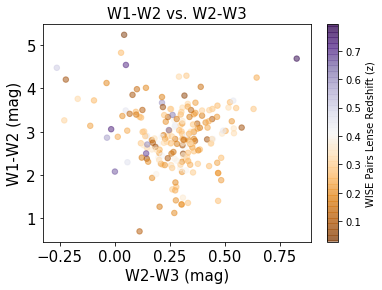

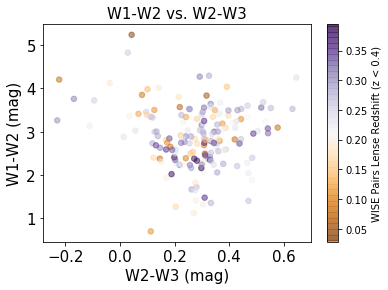

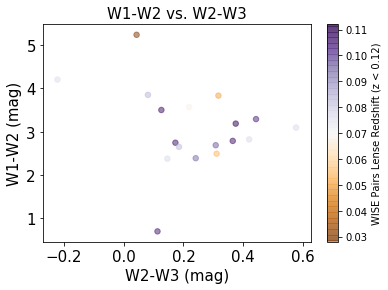

In [130]:
# Plotting all pairs, all redshifts
plt.figure()
plt.subplot(111)
plt.title("W1-W2 vs. W2-W3",fontsize=15)
p = plt.scatter(observed_color_W1, observed_color_W3, marker='o', s=30, alpha=0.5, c=merged_data.z1, cmap=cm.PuOr)
#p = plt.scatter(log_Mstar_Lum_W1,observed_color_W3, marker='o', s=30, alpha=0.5, c=merged_data.z1, cmap=cm.PuOr)

    
p = plt.cbar = plt.colorbar(p, shrink=1, orientation='vertical') #, anchor=(0,1.5))
p = plt.cbar.set_label('WISE Pairs Lense Redshift (z)', fontsize=10)
p = plt.tick_params(axis='both', which='major', labelsize=15)
p = plt.tick_params(axis='both', which='minor', labelsize=15)

p = plt.ylabel(r'W1-W2 (mag)', fontsize=15)
p = plt.xlabel(r'W2-W3 (mag)', fontsize=15)

# Plotting all pairs where z < 0.4

observed_color_W1_lowz = merged_data[merged_data.z1 < 0.4].w1mpro - merged_data[merged_data.z1 < 0.4].w2mpro #W1-W2
observed_color_W3_lowz = merged_data[merged_data.z1 < 0.4].w2mpro - merged_data[merged_data.z1 < 0.4].w3mpro #W2-W3


plt.figure()
plt.subplot(111)
plt.title("W1-W2 vs. W2-W3",fontsize=15)
p = plt.scatter(observed_color_W1_lowz,observed_color_W3_lowz, s=30, marker='o', alpha=0.5, c=merged_data[merged_data.z1 < 0.4].z1, cmap=cm.PuOr)
    
p = plt.cbar = plt.colorbar(p, shrink=1, orientation='vertical') #, anchor=(0,1.5))
p = plt.cbar.set_label('WISE Pairs Lense Redshift (z < 0.4)', fontsize=10)
p = plt.tick_params(axis='both', which='major', labelsize=15)
p = plt.tick_params(axis='both', which='minor', labelsize=15)
p = plt.ylabel(r'W1-W2 (mag)', fontsize=15)
p = plt.xlabel(r'W2-W3 (mag)', fontsize=15)

# Plotting all pairs where z < 0.4

observed_color_W1_lowz = merged_data[merged_data.z1 < 0.12].w1mpro - merged_data[merged_data.z1 < 0.12].w2mpro #W1-W2
observed_color_W3_lowz = merged_data[merged_data.z1 < 0.12].w2mpro - merged_data[merged_data.z1 < 0.12].w3mpro #W2-W3


plt.figure()
plt.subplot(111)
plt.title("W1-W2 vs. W2-W3",fontsize=15)
p = plt.scatter(observed_color_W1_lowz,observed_color_W3_lowz, s=30, marker='o', alpha=0.5, c=merged_data[merged_data.z1 < 0.12].z1, cmap=cm.PuOr)
    
p = plt.cbar = plt.colorbar(p, shrink=1, orientation='vertical') #, anchor=(0,1.5))
p = plt.cbar.set_label('WISE Pairs Lense Redshift (z < 0.12)', fontsize=10)
p = plt.tick_params(axis='both', which='major', labelsize=15)
p = plt.tick_params(axis='both', which='minor', labelsize=15)
p = plt.ylabel(r'W1-W2 (mag)', fontsize=15)
p = plt.xlabel(r'W2-W3 (mag)', fontsize=15)